In [1]:
!git clone https://github.com/ifayost/cdb_pneumonia.git
!pip install captum

Cloning into 'cdb_pneumonia'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 89 (delta 18), reused 54 (delta 10), pack-reused 25
Unpacking objects: 100% (89/89), done.
     |████████████████████████████████| 1.4MB 4.9MB/s 


In [0]:
!mkdir /content/cdb_pneumonia/weights
!cp "/content/drive/My Drive/vgg16+VB_224x224.pt" /content/cdb_pneumonia/weights
!cp "/content/drive/My Drive/vgg16+1conv_224x224_e5.pt" /content/cdb_pneumonia/weights

In [3]:
!cd ./cdb_pneumonia; python diagnose.py crop

Crop images
100% 3/3 [00:00<00:00, 36.82it/s]
3it [00:09,  3.30s/it]


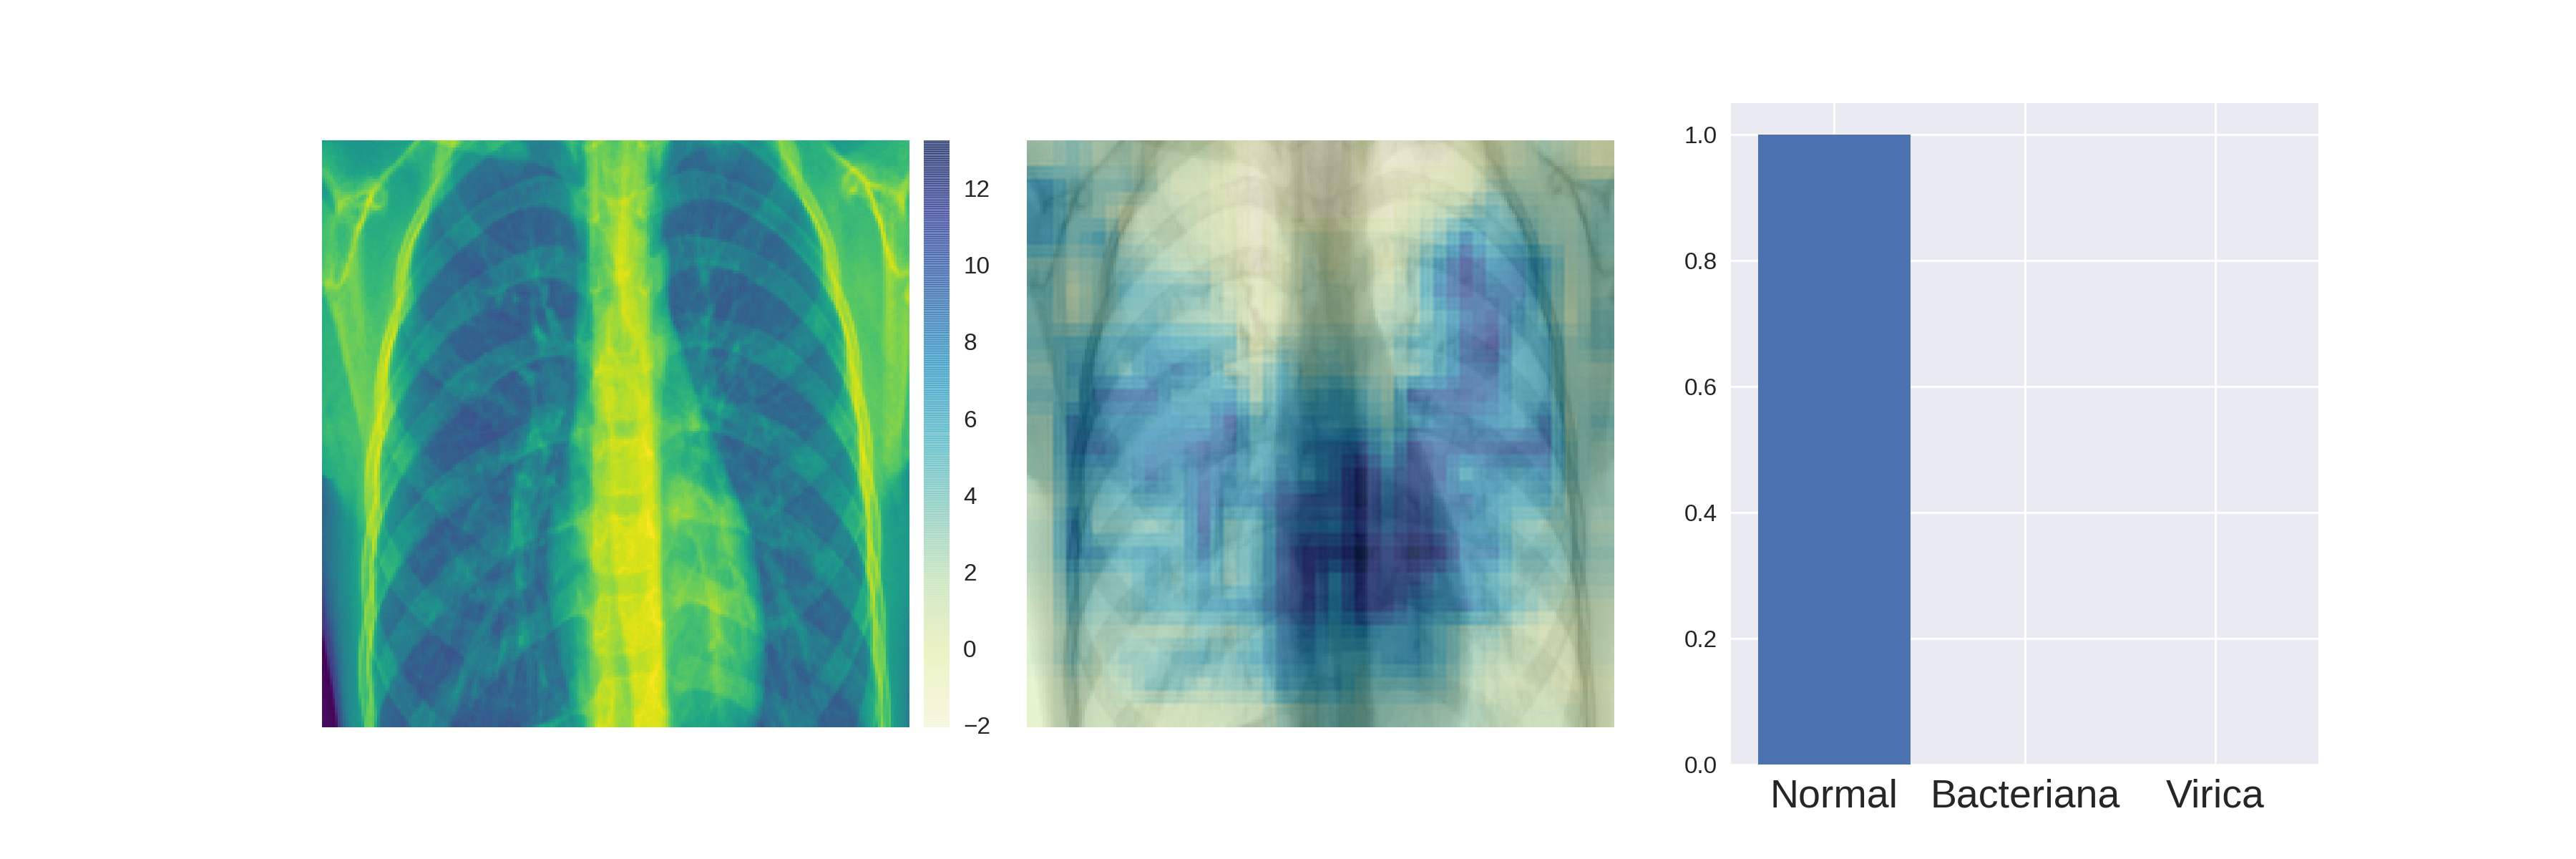

In [5]:
from PIL import Image
Image.open("/content/cdb_pneumonia/diagnoses/normal.jpeg")

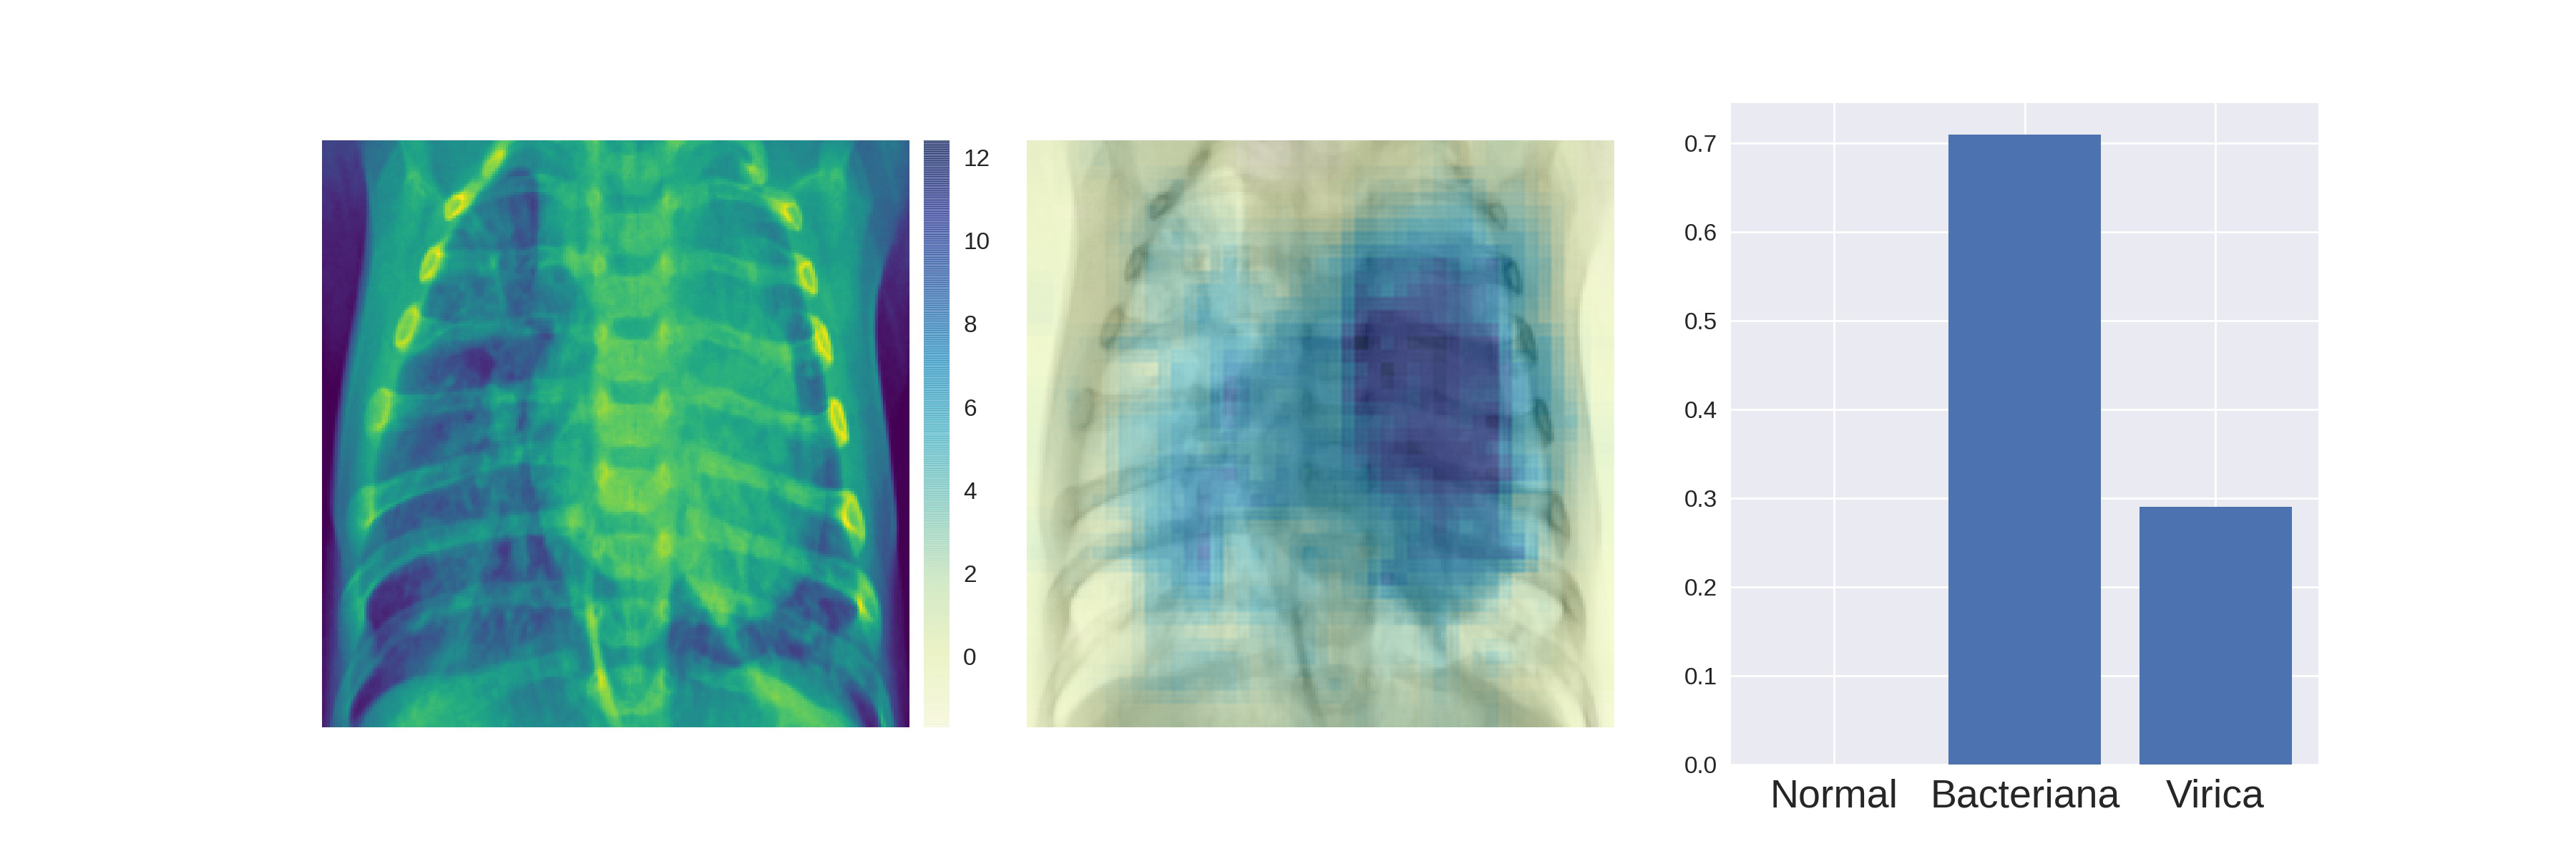

In [6]:
Image.open("/content/cdb_pneumonia/diagnoses/bacteria.jpeg")

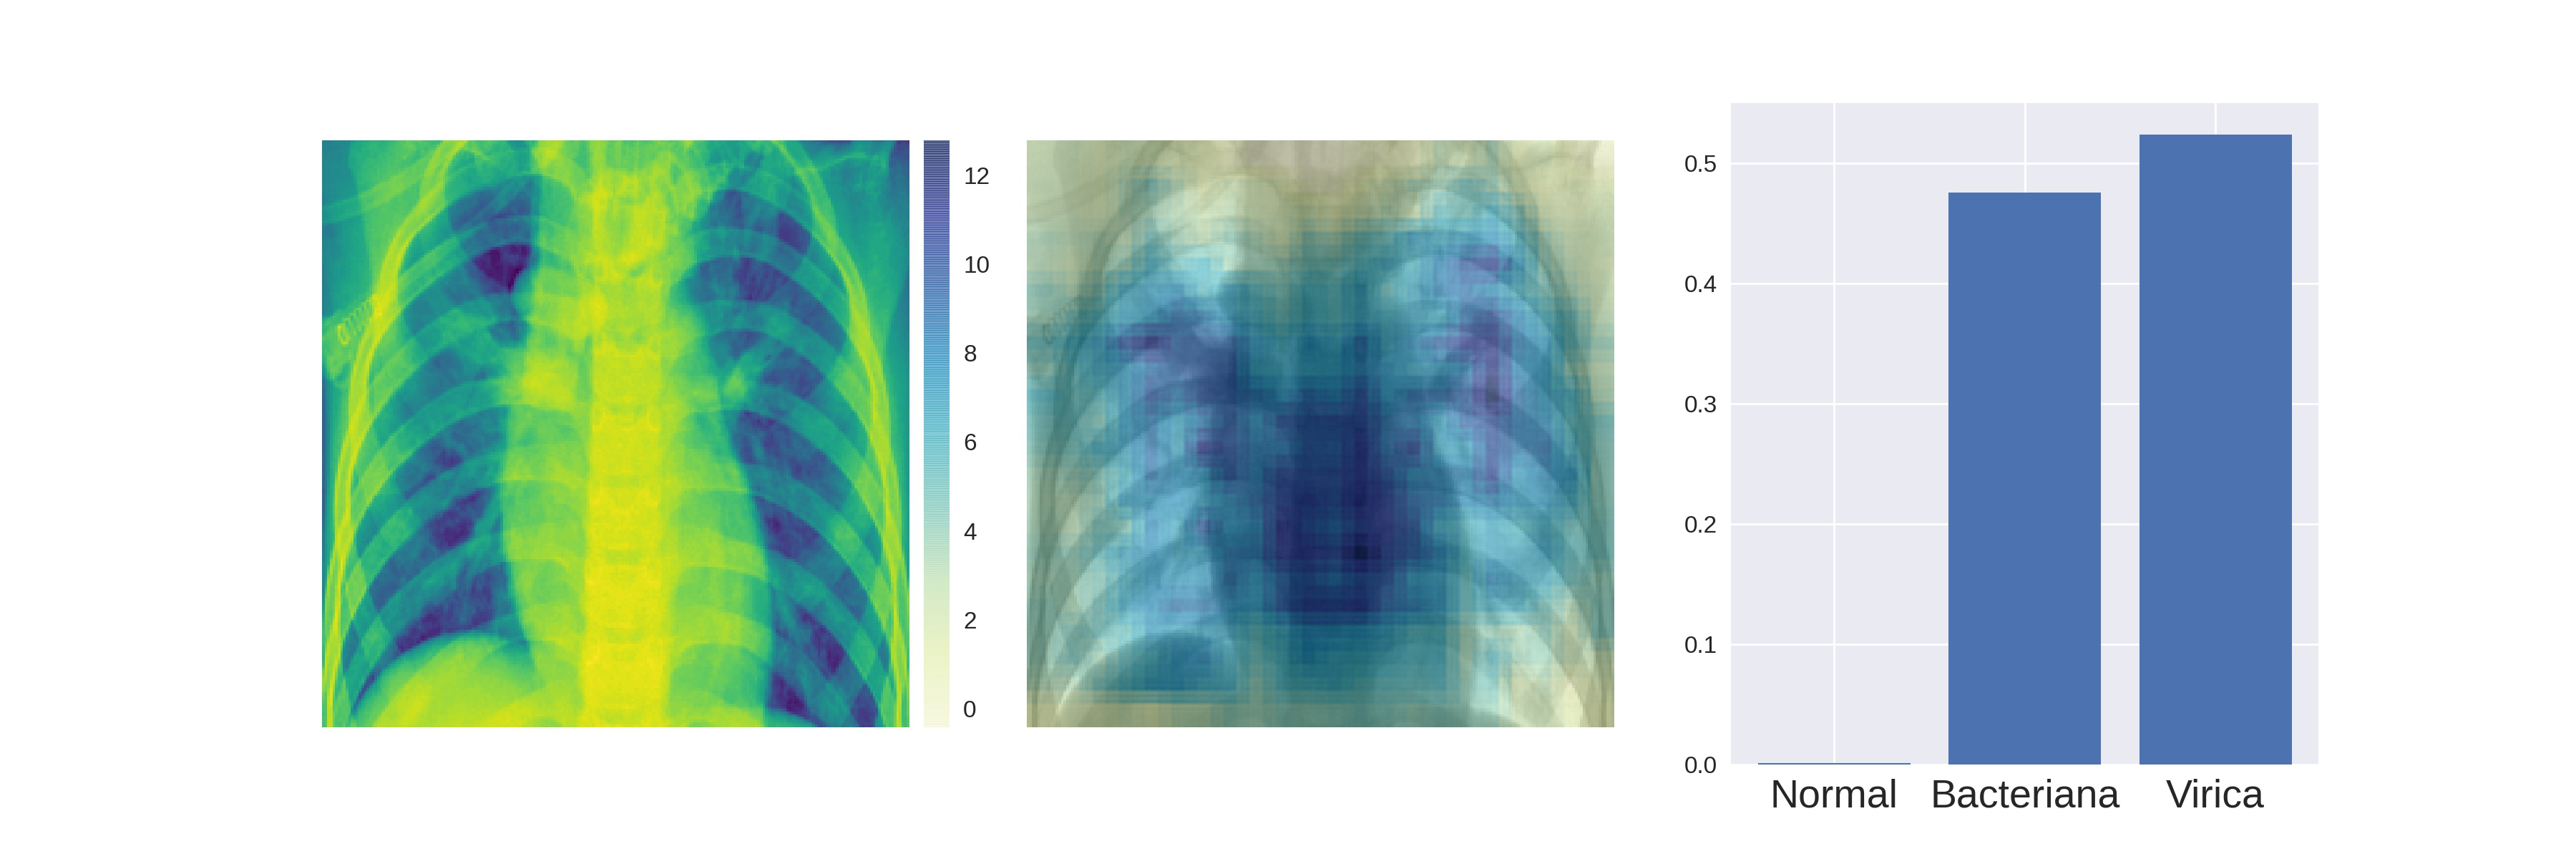

In [7]:
Image.open("/content/cdb_pneumonia/diagnoses/virus.jpeg")

In [0]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from tqdm import tqdm
from captum.attr import Occlusion
import copy
plt.style.use('seaborn')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH = "./cdb_pneumonia/test"



class_names_PN = ["Sano", "Neumonia"]
class_names_BV = ["Bacteriana", "Vírica"]

data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

image_datasets = CustomDataSet(PATH, data_transforms)
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=1)

vgg16PN = torchvision.models.vgg16(pretrained=False)
vgg16PN.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
vgg16PN = nn.Sequential(nn.Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), vgg16PN)
vgg16VB = copy.deepcopy(vgg16PN)

if device.type == "cpu":
    vgg16PN.load_state_dict(torch.load('/content/drive/My Drive/vgg16+1conv_224x224_e5.pt', map_location=torch.device('cpu')))
else:
    vgg16PN.load_state_dict(torch.load('/content/drive/My Drive/vgg16+1conv_224x224_e5.pt'))
vgg16PN = vgg16PN.to(device)
vgg16PN = vgg16PN.eval()

if vgg16VB.type == "cpu":
    vgg16VB.load_state_dict(torch.load('/content/drive/My Drive/vgg16+VB_224x224.pt', map_location=torch.device('cpu')))
else:
    vgg16VB.load_state_dict(torch.load('/content/drive/My Drive/vgg16+VB_224x224.pt'))
vgg16VB = vgg16VB.to(device)
vgg16VB = vgg16VB.eval()

In [0]:
def prediction(inp):
    outputs = vgg16PN(inp)
    probN = F.softmax(outputs, 1)[0][0].detach().cpu().numpy()
    if int(np.round(probN)) == 0:
        outputs = vgg16VB(inp)
        probsVB = F.softmax(outputs, 1)[0].detach().cpu().numpy()
    else:
      probsVB = (1-probN)/2 * np.ones(2)
    probs = np.append(probN, probsVB)
    return probs/np.sum(probs)

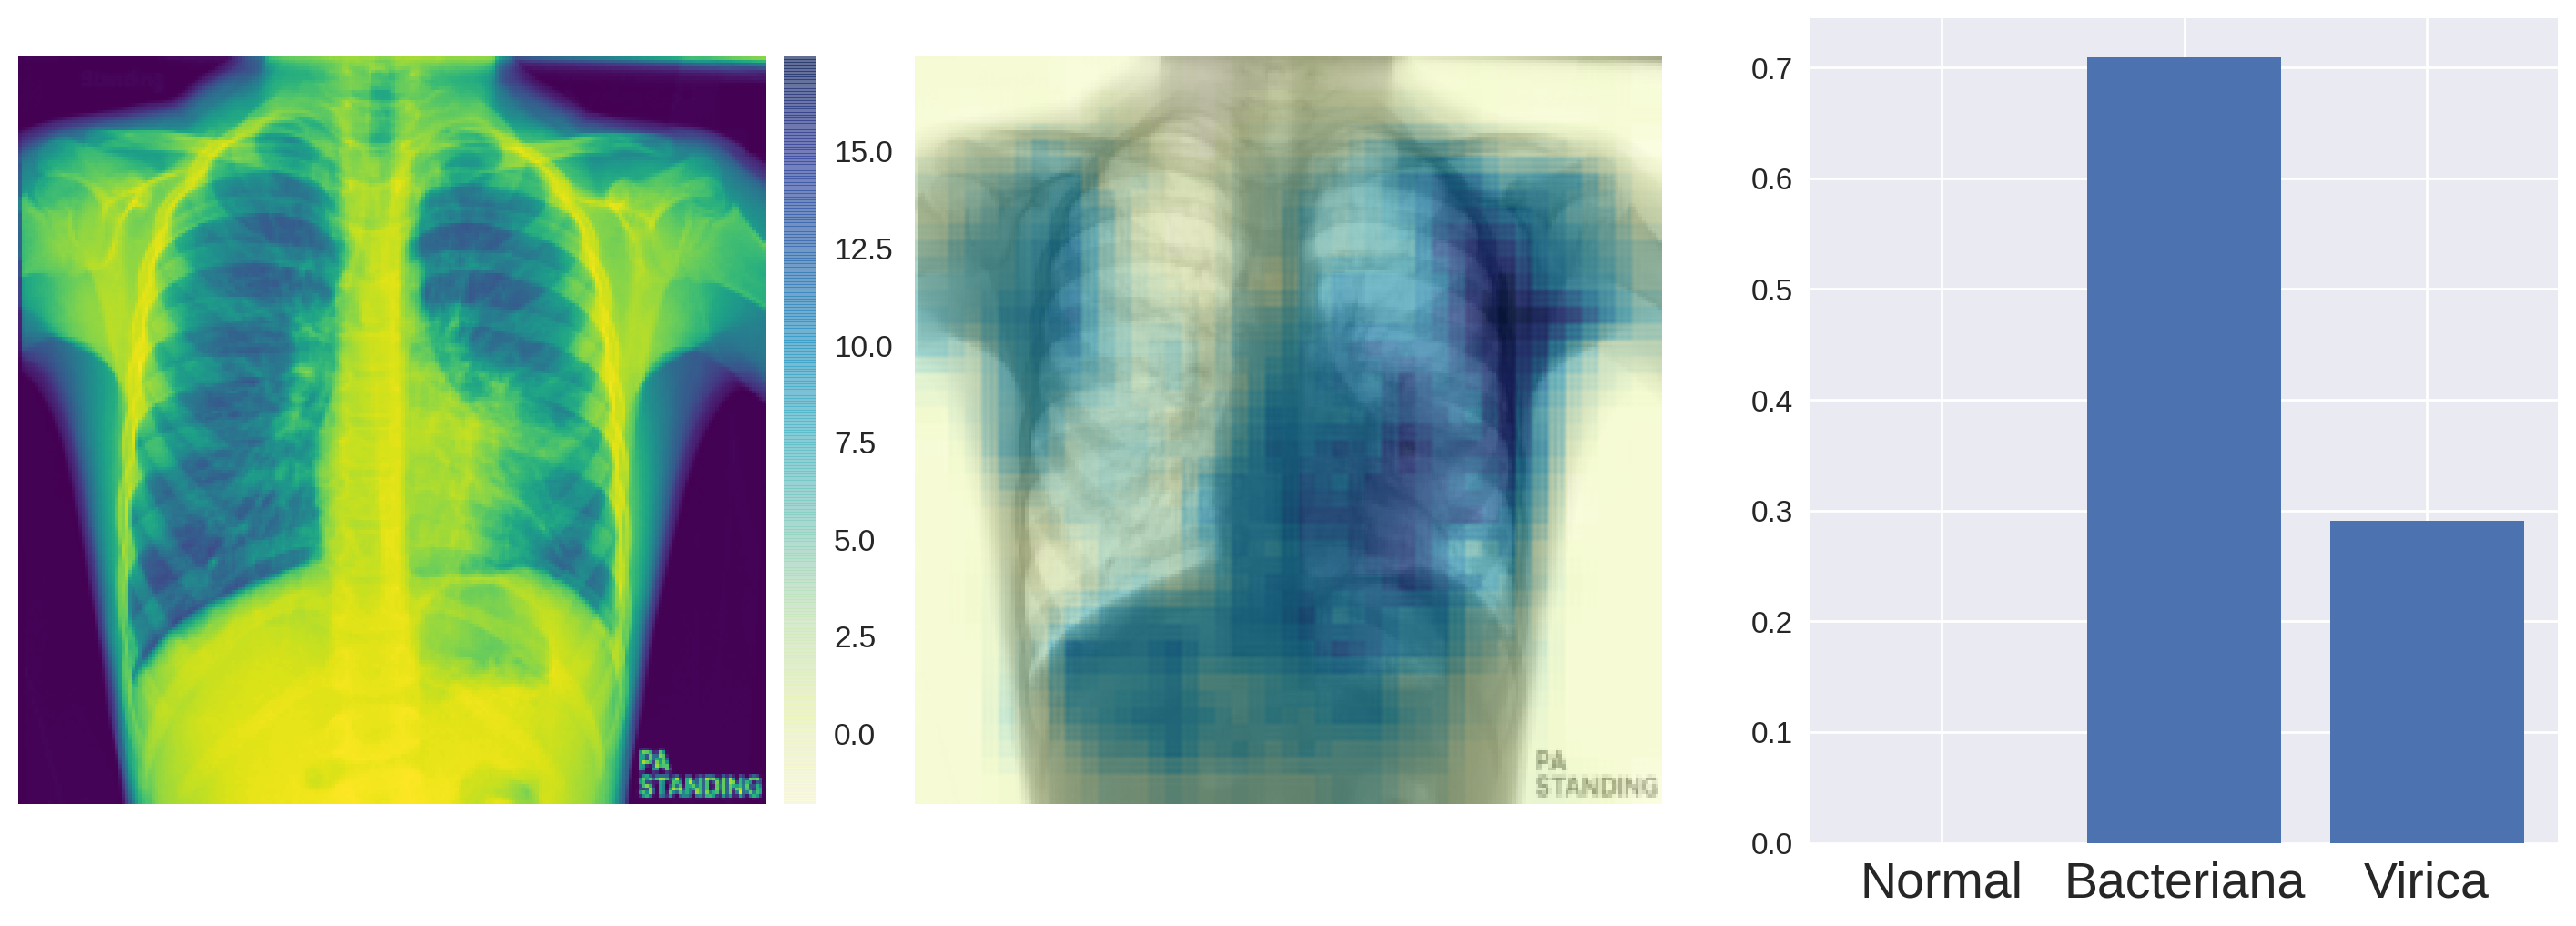

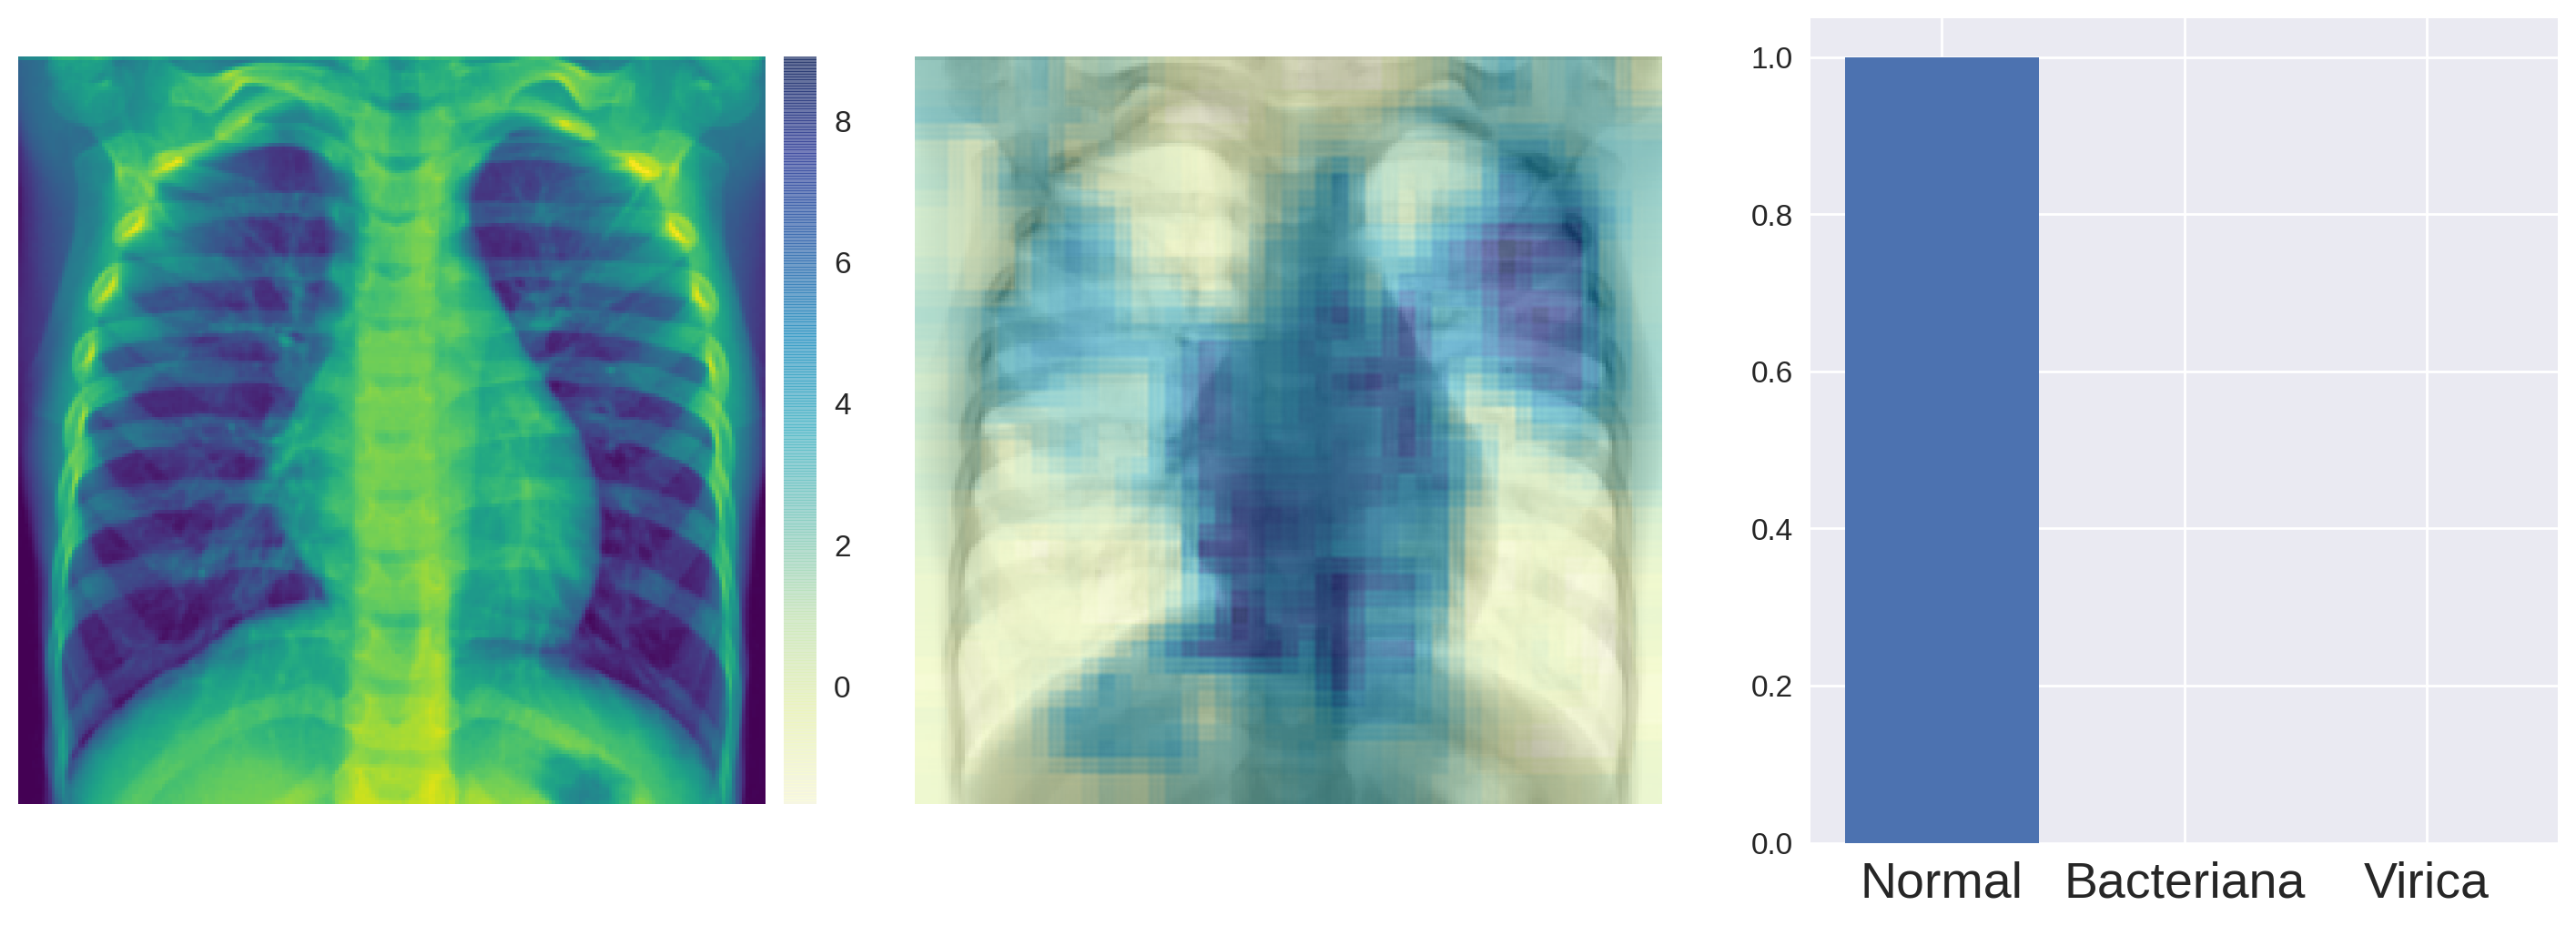

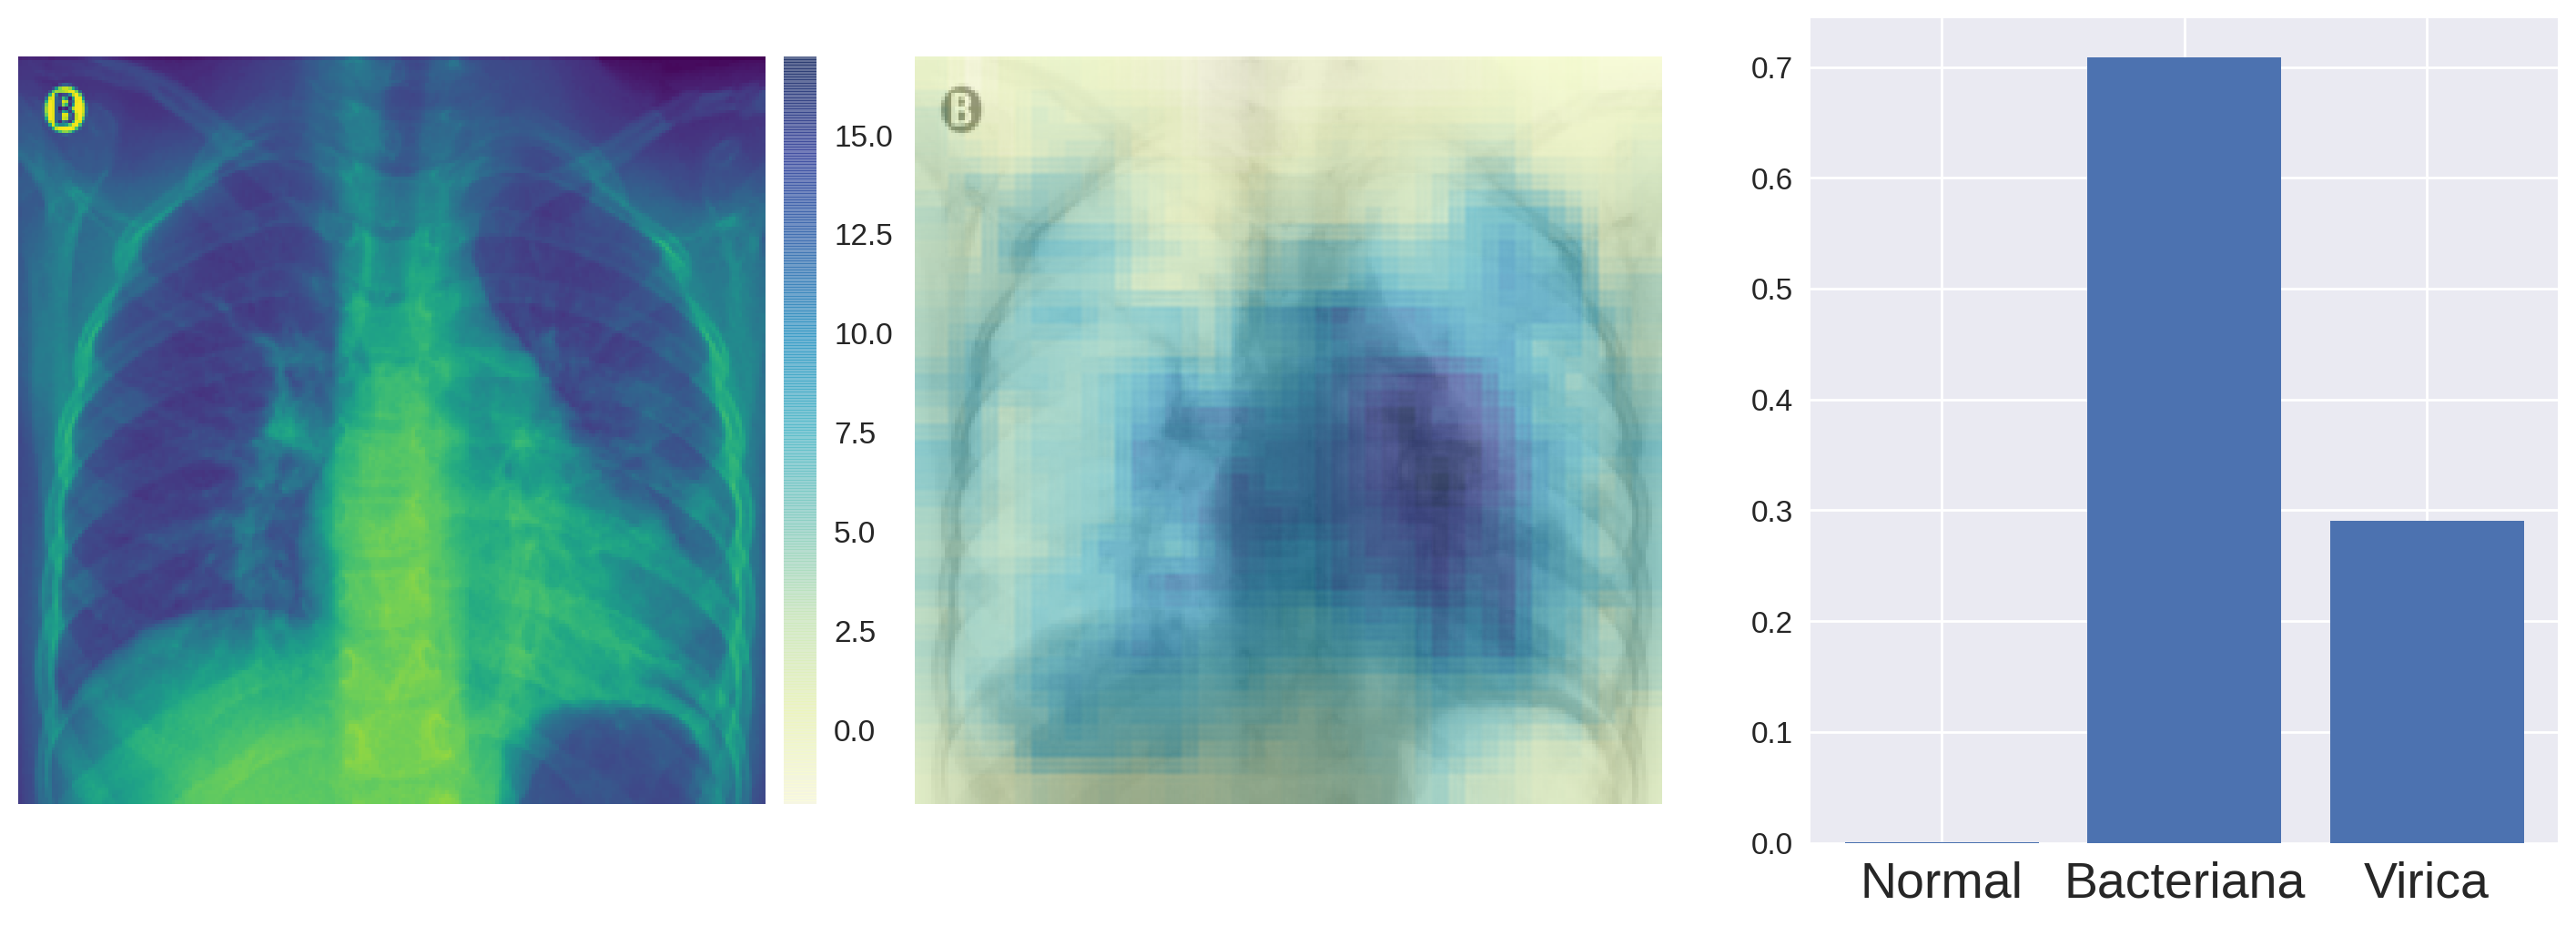

In [14]:
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 12
occlusion = Occlusion(vgg16PN)
for inp, filename in zip(dataloaders, image_datasets.total_imgs):
  inp = inp.to(device)
  probs = prediction(inp)
  attributions_ig = occlusion.attribute(inp,
                                        strides = (1, 10, 10),
                                        target=0,
                                        sliding_window_shapes=(1, 15, 15),
                                        baselines=0)
  
  fig = plt.figure(figsize=(18,6), dpi=200)
  ax1 = fig.add_subplot(131)
  ax1.imshow((inp.squeeze().cpu().detach().numpy()), cmap='viridis')
  ax1.axis('off');

  ax2 = fig.add_subplot(132)
  ax2.imshow((inp.squeeze().cpu().detach().numpy()), cmap='Greys')
  im = ax2.imshow(attributions_ig.squeeze().cpu().detach().numpy(), alpha=0.6, cmap='YlGnBu', interpolation='sinc')
  ax2.axis('off');

  ax3 = fig.add_subplot(133)
  ax3.bar(range(3), probs)
  ax3.set_xticks(range(3))
  ax3.set_xticklabels(["Normal", "Bacteriana", "Virica"])

  box2 = np.array(ax2.get_position())
  cbar_ax = fig.add_axes([box2[0,0]-0.04 , box2[0,1], 0.01, box2[1,1]-box2[0,1]])
  fig.colorbar(im, cax=cbar_ax)
  #fig.savefig(os.path.join("diagnoses", filename))

In [16]:
!pip install kaggle
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle
!cd ./cdb_pneumonia; python download_data.py
#!python cdb_pneumonia/transform_images.py cdb_pneumonia/chest_xray test
!cd ./cdb_pneumonia; python transform_dataset.py chest_xray

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 4/4 [00:00<00:00, 24.02it/s]


In [0]:
from torchvision import datasets, transforms
PATH = './cdb_pneumonia/chest_xray'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ColorJitter(brightness=(0.9,1.1), contrast=(1,1.1)),
        transforms.ToTensor()]),
    'val':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()]),
    'test':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = np.array(image_datasets['train'].classes)
class_samples = {x: np.sum([1 for _ in os.listdir(os.path.join(PATH, 'train', x))])
                for x in class_names}
weights = 1. / torch.tensor(list(class_samples.values()), dtype=torch.float).to(device)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True,
                                              batch_size=1, num_workers=2)
              for x in ['train', 'val', 'test']}

In [0]:
indices = [1,0,2]
class_names = class_names[indices]

In [0]:
aciertos = []
random = []
predicciones = []
true = []
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    probs = prediction(inputs)
    preds = np.argmax(probs)
    predicciones.append(preds)
    label = indices[int(labels.numpy()[0])]
    true.append(label)
    aciertos.append(preds==label)
    random.append(np.random.randint(0,2) == labels.numpy())

In [43]:
print(f'Model Accuracy: {np.sum(aciertos)/len(aciertos)}')
print(f'Random Accuracy: {np.sum(random)/len(random)}')

Model Accuracy: 0.8621794871794872
Random Accuracy: 0.36378205128205127


In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def confusion_mat(y_true,y_pred,labels):
    cm=confusion_matrix(y_true,y_pred,labels=labels)
    ax= plt.subplot()
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, ax = ax, fmt='', cmap='viridis');
    ax.set_xlabel('Predicted labels'); 
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.set_xticklabels(labels,rotation=0); 
    ax.set_yticklabels(labels,rotation=90);

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [49]:
{x: np.sum([1 for _ in os.listdir(os.path.join(PATH, 'test', x))])
                for x in class_names}

{'BACTERIA': 242, 'NORMAL': 234, 'VIRUS': 148}

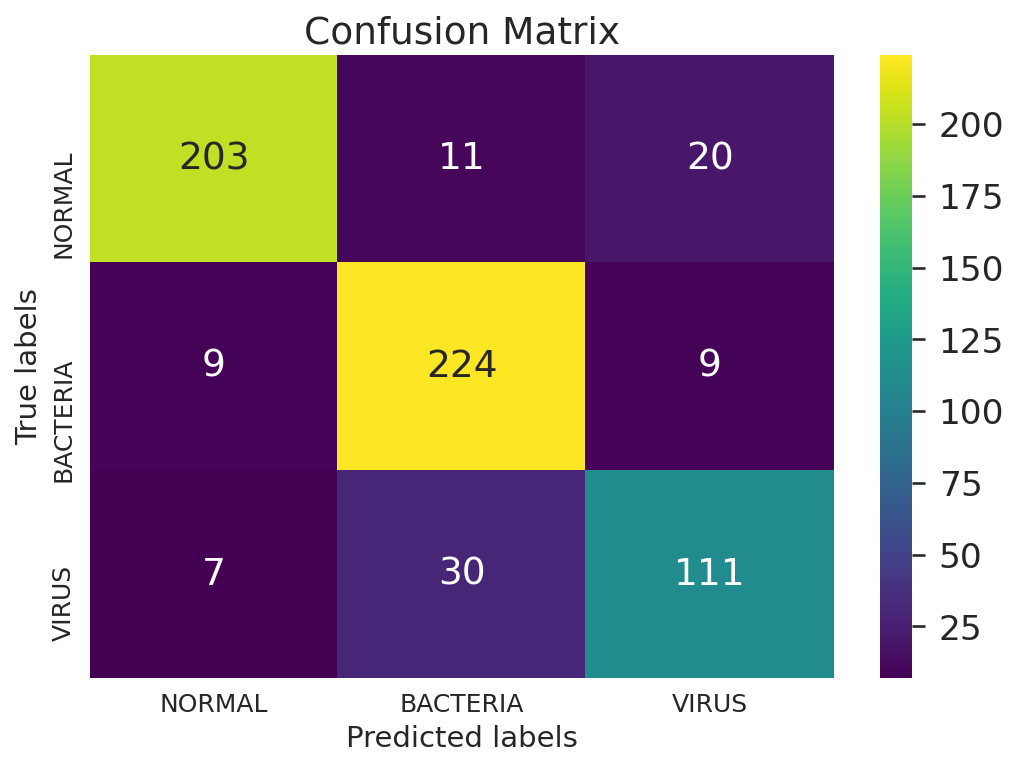

In [48]:
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig = plt.figure(dpi=150)
confusion_mat(class_names[true], class_names[predicciones], class_names)